In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier 
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV, StratifiedKFold, KFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, recall_score, roc_auc_score,roc_curve, accuracy_score, precision_score,\
f1_score, confusion_matrix, plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.utils import resample
from sklearn.metrics import auc
from sklearn.feature_selection import SelectFromModel
import time
import warnings
warnings.filterwarnings("ignore")

In [3]:
t0 = time.time()
df = pd.read_csv('lending-club-loan-data/df_modeling.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
t1 = time.time()
print('Cell Runtime: {}'.format(t1-t0))

Cell Runtime: 43.42382216453552


In [4]:
y = df['loan_status']
X = df.drop('loan_status',axis=1)

### Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Sampling the train set for faster computation time

In [77]:
ytrain_Xtrain=pd.concat([y_train, X_train], axis=1)
ytrain_Xtrain_sample = ytrain_Xtrain.sample(10000, random_state=42)
y_s = ytrain_Xtrain_sample['loan_status']
X_s = ytrain_Xtrain_sample.drop('loan_status',axis=1)

# Random Forest

Model Train Recall: 0.6844664733938091
Model Train Precision: 0.6792575406032483
Model Train F1: 0.6818520588783306
Model Train Accuracy: 0.6806321892827083


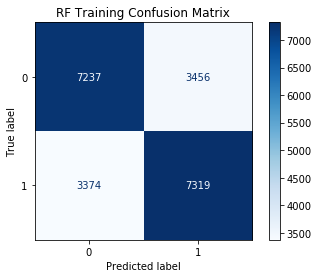

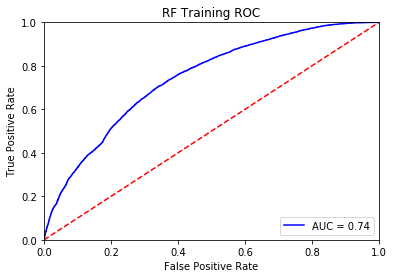

-----------------------------------
Model CrossVal Recall: 0.6348195329087049
Model CrossVal Precision: 0.20982456140350877
Model CrossVal F1: 0.3154008438818565
Model CrossVal Accuracy: 0.6755


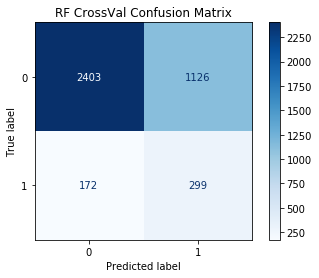

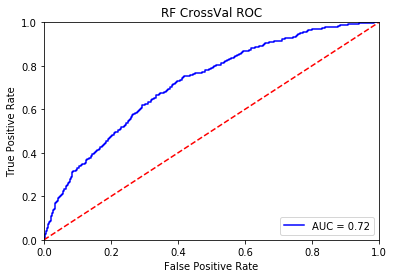

Important Features: ['int_rate', 'dti', 'inq_last_6mths', 'open_act_il', 'open_il_24m', 'total_bal_il', 'il_util', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_rcnt_rev_tl_op', 'num_tl_op_past_12m', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bc_limit', 'term', 'grade', 'sub_grade', 'Not Verified']
Cell Runtime: 18.88354992866516


In [71]:
t0 = time.time()

model=RandomForestClassifier(max_depth=5)

cv = KFold(n_splits=25)

sampler = RandomUnderSampler(random_state=42)
    
train_scores_recall = []
train_scores_precision = []
train_scores_f1 = []
train_scores_accuracy = []
    
cv_scores_recall = []
cv_scores_precision = []
cv_scores_f1 = []
cv_scores_accuracy = []

for train_fold_index, val_fold_index in cv.split(X_s, y_s):
    # Get the training data
    X_train_fold, y_train_fold = X_s.iloc[train_fold_index], y_s.iloc[train_fold_index]
    # Get the validation data
    X_val_fold, y_val_fold = X_s.iloc[val_fold_index], y_s.iloc[val_fold_index]

# Balance only the data in the training section
X_train_fold_resamp, y_train_fold_resamp = sampler.fit_resample(X_train_fold,y_train_fold)
# Fit the model on the balanced training data
model_obj = model.fit(X_train_fold_resamp, y_train_fold_resamp)
        
# Score the model on the (balanced) training data
train_score_recall = recall_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_recall.append(train_score_recall)
        
train_score_precision = precision_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_precision.append(train_score_precision)
        
train_score_f1 = f1_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_f1.append(train_score_f1)
        
train_score_accuracy = accuracy_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_accuracy.append(train_score_accuracy)
        
# Score the model on the (non-balanced) validation data
score_recall = recall_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_recall.append(score_recall)
        
score_precision = precision_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_precision.append(score_precision)
        
score_f1 = f1_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_f1.append(score_f1)
        
score_accuracy = accuracy_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_accuracy.append(score_accuracy)

print('Model Train Recall: {}'.format(np.array(train_scores_recall).mean()))
print('Model Train Precision: {}'.format(np.array(train_scores_precision).mean()))
print('Model Train F1: {}'.format(np.array(train_scores_f1).mean()))
print('Model Train Accuracy: {}'.format(np.array(train_scores_accuracy).mean()))

disp1=plot_confusion_matrix(model_obj, X_train_fold_resamp, y_train_fold_resamp, cmap=plt.cm.Blues, values_format = 'd')         
disp1.ax_.set_title('RF Training Confusion Matrix')
plt.grid(False)
plt.show()

y_score = model_obj.predict_proba(X_train_fold_resamp)[:,1]
fpr, tpr, threshold = roc_curve(y_train_fold_resamp, y_score)
roc_auc = auc(fpr, tpr)

plt.title('RF Training ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('-----------------------------------')
print('Model CrossVal Recall: {}'.format(np.array(cv_scores_recall).mean()))
print('Model CrossVal Precision: {}'.format(np.array(cv_scores_precision).mean()))
print('Model CrossVal F1: {}'.format(np.array(cv_scores_f1).mean()))
print('Model CrossVal Accuracy: {}'.format(np.array(cv_scores_accuracy).mean()))

disp1=plot_confusion_matrix(model_obj, X_val_fold, y_val_fold, cmap=plt.cm.Blues, values_format = 'd', )         
disp1.ax_.set_title('RF CrossVal Confusion Matrix')
plt.grid(False)
plt.show()

y_score = model_obj.predict_proba(X_val_fold)[:,1]
fpr, tpr, threshold = roc_curve(y_val_fold, y_score)
roc_auc = auc(fpr, tpr)

plt.title('RF CrossVal ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

sel = SelectFromModel(model_obj)
sel.fit(X_s, y_s)
mask = sel.get_support()
rf_important_features = list(X_s.loc[:,mask].columns)
print('Important Features: {}'.format(rf_important_features))

t1 = time.time()
print('Cell Runtime: {}'.format(t1-t0))

# Gradient Boosting

Model Train Recall: 0.8519337016574585
Model Train Precision: 0.7973112719751809
Model Train F1: 0.8237179487179487
Model Train Accuracy: 0.8176795580110497


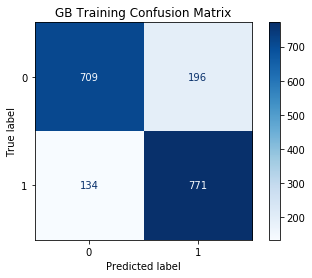

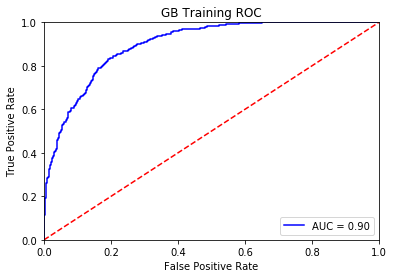

-----------------------------------
Model CrossVal Recall: 0.6428571428571429
Model CrossVal Precision: 0.19148936170212766
Model CrossVal F1: 0.29508196721311475
Model CrossVal Accuracy: 0.6345


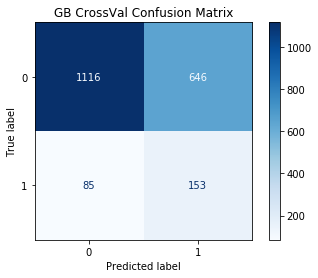

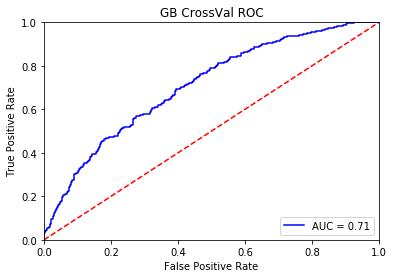

Important Features: ['int_rate', 'installment', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'open_il_24m', 'il_util', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'num_bc_tl', 'num_sats', 'pct_tl_nvr_dlq', 'tot_hi_cred_lim', 'total_bc_limit', 'grade', 'sub_grade', 'earliest_cr_line', 'MORTGAGE']
Cell Runtime: 11.828518152236938


In [52]:
t0 = time.time()

model=GradientBoostingClassifier()

cv = KFold(n_splits=5, random_state=42)

sampler = RandomUnderSampler(random_state=42)
    
train_scores_recall = []
train_scores_precision = []
train_scores_f1 = []
train_scores_accuracy = []
    
cv_scores_recall = []
cv_scores_precision = []
cv_scores_f1 = []
cv_scores_accuracy = []

for train_fold_index, val_fold_index in cv.split(X_s, y_s):
    # Get the training data
    X_train_fold, y_train_fold = X_s.iloc[train_fold_index], y_s.iloc[train_fold_index]
    # Get the validation data
    X_val_fold, y_val_fold = X_s.iloc[val_fold_index], y_s.iloc[val_fold_index]

# Balance only the data in the training section
X_train_fold_resamp, y_train_fold_resamp = sampler.fit_resample(X_train_fold,y_train_fold)
# Fit the model on the upsampled training data
model_obj = model.fit(X_train_fold_resamp, y_train_fold_resamp)
        
# Score the model on the (balanced) training data
train_score_recall = recall_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_recall.append(train_score_recall)
        
train_score_precision = precision_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_precision.append(train_score_precision)
        
train_score_f1 = f1_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_f1.append(train_score_f1)
        
train_score_accuracy = accuracy_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_accuracy.append(train_score_accuracy)
        
# Score the model on the (non-balanced) validation data
score_recall = recall_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_recall.append(score_recall)
        
score_precision = precision_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_precision.append(score_precision)
        
score_f1 = f1_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_f1.append(score_f1)
        
score_accuracy = accuracy_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_accuracy.append(score_accuracy)

print('Model Train Recall: {}'.format(np.array(train_scores_recall).mean()))
print('Model Train Precision: {}'.format(np.array(train_scores_precision).mean()))
print('Model Train F1: {}'.format(np.array(train_scores_f1).mean()))
print('Model Train Accuracy: {}'.format(np.array(train_scores_accuracy).mean()))

disp1=plot_confusion_matrix(model_obj, X_train_fold_resamp, y_train_fold_resamp, cmap=plt.cm.Blues, values_format = 'd', )         
disp1.ax_.set_title('GB Training Confusion Matrix')
plt.grid(False)
plt.show()

y_score = model_obj.predict_proba(X_train_fold_resamp)[:,1]
fpr, tpr, threshold = roc_curve(y_train_fold_resamp, y_score)
roc_auc = auc(fpr, tpr)

plt.title('GB Training ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('-----------------------------------')
print('Model CrossVal Recall: {}'.format(np.array(cv_scores_recall).mean()))
print('Model CrossVal Precision: {}'.format(np.array(cv_scores_precision).mean()))
print('Model CrossVal F1: {}'.format(np.array(cv_scores_f1).mean()))
print('Model CrossVal Accuracy: {}'.format(np.array(cv_scores_accuracy).mean()))

disp1=plot_confusion_matrix(model_obj, X_val_fold, y_val_fold, cmap=plt.cm.Blues, values_format = 'd', )         
disp1.ax_.set_title('GB CrossVal Confusion Matrix')
plt.grid(False)
plt.show()

y_score = model_obj.predict_proba(X_val_fold)[:,1]
fpr, tpr, threshold = roc_curve(y_val_fold, y_score)
roc_auc = auc(fpr, tpr)

plt.title('GB CrossVal ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

sel = SelectFromModel(model_obj)
sel.fit(X_s, y_s)
mask = sel.get_support()
gb_important_features = list(X_s.loc[:,mask].columns)
print('Important Features: {}'.format(gb_important_features))

t1 = time.time()
print('Cell Runtime: {}'.format(t1-t0))

# AdaBoost

Model Train Recall: 0.980110497237569
Model Train Precision: 0.9446219382321619
Model Train F1: 0.9620390455531453
Model Train Accuracy: 0.9613259668508287


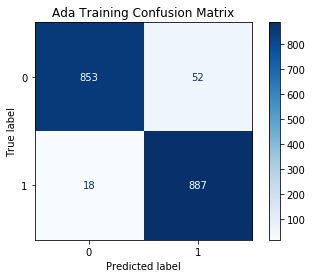

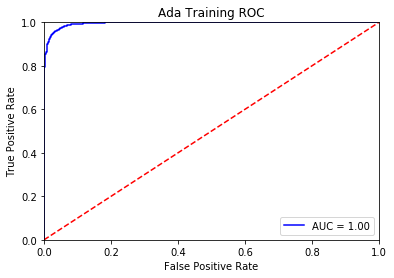

-----------------------------------
Model CrossVal Recall: 0.634453781512605
Model CrossVal Precision: 0.19842312746386334
Model CrossVal F1: 0.3023023023023023
Model CrossVal Accuracy: 0.6515


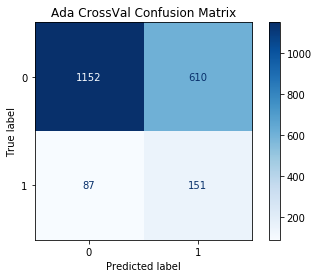

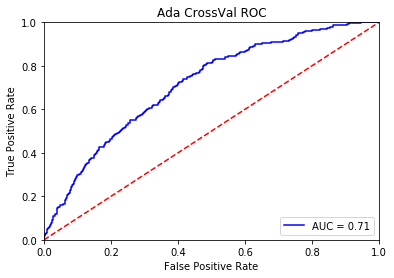

Important Features: ['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'tot_coll_amt', 'tot_cur_bal', 'open_act_il', 'total_bal_il', 'il_util', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'grade', 'sub_grade', 'earliest_cr_line']
Cell Runtime: 76.26977205276489


In [51]:
t0 = time.time()

model=AdaBoostClassifier(RandomForestClassifier(max_depth=3))

cv = KFold(n_splits=5, random_state=42)

sampler = RandomUnderSampler(random_state=42)
    
train_scores_recall = []
train_scores_precision = []
train_scores_f1 = []
train_scores_accuracy = []
    
cv_scores_recall = []
cv_scores_precision = []
cv_scores_f1 = []
cv_scores_accuracy = []

for train_fold_index, val_fold_index in cv.split(X_s, y_s):
    # Get the training data
    X_train_fold, y_train_fold = X_s.iloc[train_fold_index], y_s.iloc[train_fold_index]
    # Get the validation data
    X_val_fold, y_val_fold = X_s.iloc[val_fold_index], y_s.iloc[val_fold_index]

# Balance only the data in the training section
X_train_fold_resamp, y_train_fold_resamp = sampler.fit_resample(X_train_fold,y_train_fold)
# Fit the model on the upsampled training data
model_obj = model.fit(X_train_fold_resamp, y_train_fold_resamp)
        
# Score the model on the (balanced) training data
train_score_recall = recall_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_recall.append(train_score_recall)
        
train_score_precision = precision_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_precision.append(train_score_precision)
        
train_score_f1 = f1_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_f1.append(train_score_f1)
        
train_score_accuracy = accuracy_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_accuracy.append(train_score_accuracy)
        
# Score the model on the (non-balanced) validation data
score_recall = recall_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_recall.append(score_recall)
        
score_precision = precision_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_precision.append(score_precision)
        
score_f1 = f1_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_f1.append(score_f1)
        
score_accuracy = accuracy_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_accuracy.append(score_accuracy)

print('Model Train Recall: {}'.format(np.array(train_scores_recall).mean()))
print('Model Train Precision: {}'.format(np.array(train_scores_precision).mean()))
print('Model Train F1: {}'.format(np.array(train_scores_f1).mean()))
print('Model Train Accuracy: {}'.format(np.array(train_scores_accuracy).mean()))

disp1=plot_confusion_matrix(model_obj, X_train_fold_resamp, y_train_fold_resamp, cmap=plt.cm.Blues, values_format = 'd', )         
disp1.ax_.set_title('Ada Training Confusion Matrix')
plt.grid(False)
plt.show()

y_score = model_obj.predict_proba(X_train_fold_resamp)[:,1]
fpr, tpr, threshold = roc_curve(y_train_fold_resamp, y_score)
roc_auc = auc(fpr, tpr)

plt.title('Ada Training ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('-----------------------------------')
print('Model CrossVal Recall: {}'.format(np.array(cv_scores_recall).mean()))
print('Model CrossVal Precision: {}'.format(np.array(cv_scores_precision).mean()))
print('Model CrossVal F1: {}'.format(np.array(cv_scores_f1).mean()))
print('Model CrossVal Accuracy: {}'.format(np.array(cv_scores_accuracy).mean()))

disp1=plot_confusion_matrix(model_obj, X_val_fold, y_val_fold, cmap=plt.cm.Blues, values_format = 'd', )         
disp1.ax_.set_title('Ada CrossVal Confusion Matrix')
plt.grid(False)
plt.show()

y_score = model_obj.predict_proba(X_val_fold)[:,1]
fpr, tpr, threshold = roc_curve(y_val_fold, y_score)
roc_auc = auc(fpr, tpr)

plt.title('Ada CrossVal ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

sel = SelectFromModel(model_obj)
sel.fit(X_s, y_s)
mask = sel.get_support()
ada_important_features = list(X_s.loc[:,mask].columns)
print('Important Features: {}'.format(ada_important_features))

t1 = time.time()
print('Cell Runtime: {}'.format(t1-t0))

# Bagging Classifier

Model Train Recall: 0.8475138121546961
Model Train Precision: 0.8073684210526316
Model Train F1: 0.8269541778975742
Model Train Accuracy: 0.8226519337016575


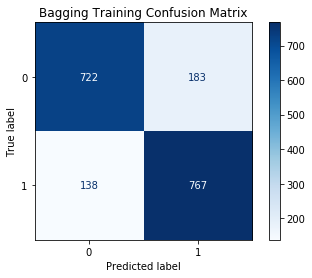

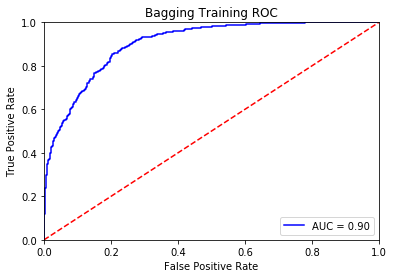

-----------------------------------
Model CrossVal Recall: 0.634453781512605
Model CrossVal Precision: 0.19894598155467721
Model CrossVal F1: 0.3029087261785356
Model CrossVal Accuracy: 0.6525


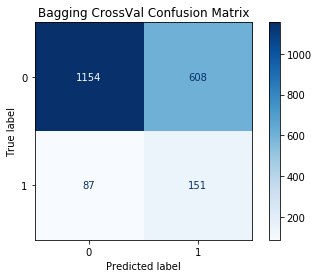

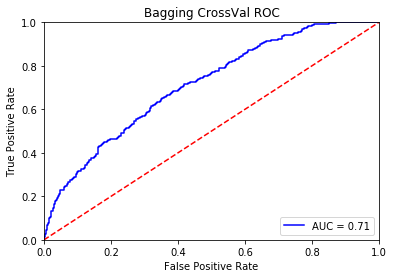

Cell Runtime: 6.774500131607056


In [50]:
t0 = time.time()

model=BaggingClassifier(RandomForestClassifier(max_depth=7))

cv = KFold(n_splits=5, random_state=42)

sampler = RandomUnderSampler(random_state=42)
    
train_scores_recall = []
train_scores_precision = []
train_scores_f1 = []
train_scores_accuracy = []
    
cv_scores_recall = []
cv_scores_precision = []
cv_scores_f1 = []
cv_scores_accuracy = []

for train_fold_index, val_fold_index in cv.split(X_sf, y_s):
    # Get the training data
    X_train_fold, y_train_fold = X_s.iloc[train_fold_index], y_s.iloc[train_fold_index]
    # Get the validation data
    X_val_fold, y_val_fold = X_s.iloc[val_fold_index], y_s.iloc[val_fold_index]

# Balance only the data in the training section
X_train_fold_resamp, y_train_fold_resamp = sampler.fit_resample(X_train_fold,y_train_fold)
# Fit the model on the upsampled training data
model_obj = model.fit(X_train_fold_resamp, y_train_fold_resamp)
        
# Score the model on the (balanced) training data
train_score_recall = recall_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_recall.append(train_score_recall)
        
train_score_precision = precision_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_precision.append(train_score_precision)
        
train_score_f1 = f1_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_f1.append(train_score_f1)
        
train_score_accuracy = accuracy_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_accuracy.append(train_score_accuracy)
        
# Score the model on the (non-balanced) validation data
score_recall = recall_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_recall.append(score_recall)
        
score_precision = precision_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_precision.append(score_precision)
        
score_f1 = f1_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_f1.append(score_f1)
        
score_accuracy = accuracy_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_accuracy.append(score_accuracy)

print('Model Train Recall: {}'.format(np.array(train_scores_recall).mean()))
print('Model Train Precision: {}'.format(np.array(train_scores_precision).mean()))
print('Model Train F1: {}'.format(np.array(train_scores_f1).mean()))
print('Model Train Accuracy: {}'.format(np.array(train_scores_accuracy).mean()))

disp1=plot_confusion_matrix(model_obj, X_train_fold_resamp, y_train_fold_resamp, cmap=plt.cm.Blues, values_format = 'd', )         
disp1.ax_.set_title('Bagging Training Confusion Matrix')
plt.grid(False)
plt.show()

y_score = model_obj.predict_proba(X_train_fold_resamp)[:,1]
fpr, tpr, threshold = roc_curve(y_train_fold_resamp, y_score)
roc_auc = auc(fpr, tpr)

plt.title('Bagging Training ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('-----------------------------------')
print('Model CrossVal Recall: {}'.format(np.array(cv_scores_recall).mean()))
print('Model CrossVal Precision: {}'.format(np.array(cv_scores_precision).mean()))
print('Model CrossVal F1: {}'.format(np.array(cv_scores_f1).mean()))
print('Model CrossVal Accuracy: {}'.format(np.array(cv_scores_accuracy).mean()))

disp1=plot_confusion_matrix(model_obj, X_val_fold, y_val_fold, cmap=plt.cm.Blues, values_format = 'd', )         
disp1.ax_.set_title('Bagging CrossVal Confusion Matrix')
plt.grid(False)
plt.show()

y_score = model_obj.predict_proba(X_val_fold)[:,1]
fpr, tpr, threshold = roc_curve(y_val_fold, y_score)
roc_auc = auc(fpr, tpr)

plt.title('Bagging CrossVal ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

t1 = time.time()
print('Cell Runtime: {}'.format(t1-t0))

In [69]:
selected_features = list(set().union(rf_important_features, gb_important_features, ada_important_features))

In [30]:
X_sf = X_s[selected_features]

In [58]:
kf = KFold(n_splits=5, random_state=42)

sampler = RandomUnderSampler(random_state=42)
model = RandomForestClassifier(n_estimators=100, max_depth=5)

pipeline = make_pipeline(sampler, model)

cross_val_recall = cross_val_score(pipeline, X_s, y_s, scoring='recall', cv=kf)
cross_val_precision = cross_val_score(pipeline, X_s, y_s, scoring='precision', cv=kf)
cross_val_f1 = cross_val_score(pipeline, X_s, y_s, scoring='f1', cv=kf)
cross_val_accuracy = cross_val_score(pipeline, X_s, y_s, scoring='accuracy', cv=kf)
print('----------------------------------')
print('Model CrossVal Recall: {}'.format(cross_val_recall.mean()))
print('Model CrossVal Precision: {}'.format(cross_val_precision.mean()))
print('Model CrossVal F1: {}'.format(cross_val_f1.mean()))
print('Model CrossVal Accuracy: {}'.format(cross_val_accuracy.mean()))

----------------------------------
Model CrossVal Recall: 0.669450612588503
Model CrossVal Precision: 0.1939573919625263
Model CrossVal F1: 0.30673558141782653
Model CrossVal Accuracy: 0.6430999999999999


[LibSVM]Model Train Recall: 0.9668508287292817
Model Train Precision: 0.5054881571346043
Model Train F1: 0.6638846737481032
Model Train Accuracy: 0.5104972375690607


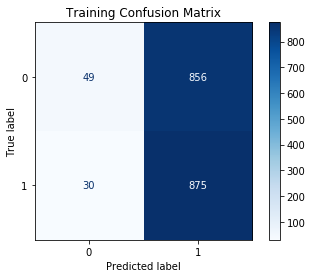

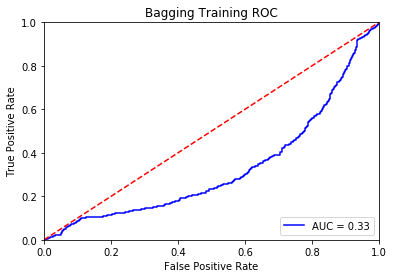

-----------------------------------
Model CrossVal Recall: 0.9747899159663865
Model CrossVal Precision: 0.12058212058212059
Model CrossVal F1: 0.21461609620721556
Model CrossVal Accuracy: 0.151


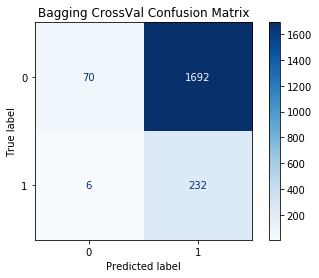

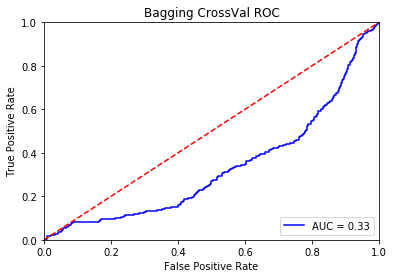

Cell Runtime: 20.72146201133728


In [82]:
t0 = time.time()

model= SVC(C=0.0001, kernel='rbf', gamma='scale', cache_size=512, verbose=2, probability=True)

cv = KFold(n_splits=5, random_state=42)

sampler = RandomUnderSampler(random_state=42)
    
train_scores_recall = []
train_scores_precision = []
train_scores_f1 = []
train_scores_accuracy = []
    
cv_scores_recall = []
cv_scores_precision = []
cv_scores_f1 = []
cv_scores_accuracy = []

for train_fold_index, val_fold_index in cv.split(X_s, y_s):
    # Get the training data
    X_train_fold, y_train_fold = X_s.iloc[train_fold_index], y_s.iloc[train_fold_index]
    # Get the validation data
    X_val_fold, y_val_fold = X_s.iloc[val_fold_index], y_s.iloc[val_fold_index]

# Balance only the data in the training section
X_train_fold_resamp, y_train_fold_resamp = sampler.fit_resample(X_train_fold,y_train_fold)
# Fit the model on the upsampled training data
model_obj = model.fit(X_train_fold_resamp, y_train_fold_resamp)
        
# Score the model on the (balanced) training data
train_score_recall = recall_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_recall.append(train_score_recall)
        
train_score_precision = precision_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_precision.append(train_score_precision)
        
train_score_f1 = f1_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_f1.append(train_score_f1)
        
train_score_accuracy = accuracy_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
train_scores_accuracy.append(train_score_accuracy)
        
# Score the model on the (non-balanced) validation data
score_recall = recall_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_recall.append(score_recall)
        
score_precision = precision_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_precision.append(score_precision)
        
score_f1 = f1_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_f1.append(score_f1)
        
score_accuracy = accuracy_score(y_val_fold, model_obj.predict(X_val_fold))
cv_scores_accuracy.append(score_accuracy)

print('Model Train Recall: {}'.format(np.array(train_scores_recall).mean()))
print('Model Train Precision: {}'.format(np.array(train_scores_precision).mean()))
print('Model Train F1: {}'.format(np.array(train_scores_f1).mean()))
print('Model Train Accuracy: {}'.format(np.array(train_scores_accuracy).mean()))

disp1=plot_confusion_matrix(model_obj, X_train_fold_resamp, y_train_fold_resamp, cmap=plt.cm.Blues, values_format = 'd', )         
disp1.ax_.set_title('Training Confusion Matrix')
plt.grid(False)
plt.show()

y_score = model_obj.predict_proba(X_train_fold_resamp)[:,1]
fpr, tpr, threshold = roc_curve(y_train_fold_resamp, y_score)
roc_auc = auc(fpr, tpr)

plt.title('Bagging Training ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('-----------------------------------')
print('Model CrossVal Recall: {}'.format(np.array(cv_scores_recall).mean()))
print('Model CrossVal Precision: {}'.format(np.array(cv_scores_precision).mean()))
print('Model CrossVal F1: {}'.format(np.array(cv_scores_f1).mean()))
print('Model CrossVal Accuracy: {}'.format(np.array(cv_scores_accuracy).mean()))

disp1=plot_confusion_matrix(model_obj, X_val_fold, y_val_fold, cmap=plt.cm.Blues, values_format = 'd', )         
disp1.ax_.set_title('Bagging CrossVal Confusion Matrix')
plt.grid(False)
plt.show()

y_score = model_obj.predict_proba(X_val_fold)[:,1]
fpr, tpr, threshold = roc_curve(y_val_fold, y_score)
roc_auc = auc(fpr, tpr)

plt.title('Bagging CrossVal ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

t1 = time.time()
print('Cell Runtime: {}'.format(t1-t0))